In [1]:
import numpy as np
import os
import re
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf

In [2]:
logMh_m = 11.5
logMh_M = 14.5
logMh_bin = 0.02
logMh_N = int((logMh_M - logMh_m) / logMh_bin)

In [ ]:
pattern = re.compile(r'result\[\(([0-9]+),([0-9]+)\)\].npy')
result = {}
for k in os.listdir():
    if k.endswith('.npy'):
        res = np.load(k)
        match_res = pattern.match(k)
        if match_res:
            i, j = match_res.groups()
            result[(int(i), int(j))] = res['npairs']

In [ ]:
result_array = np.zeros(logMh_N*(logMh_N+1)//2, dtype=[('i', int), ('j', int), ('npairs', 'uint64', len(result[(1,1)]))])
zero_array = np.zeros_like(result[(1,1)])

In [38]:
index = 0
for i in range(1, logMh_N+1):
    for j in range(1, i+1):
        result_array['i'][index] = i
        result_array['j'][index] = j
        result_array['npairs'][index] = result.get((i,j), zero_array)
        index += 1

In [40]:
np.save('halo_halo_count', result_array)

calculate the wp

In [4]:
result_array = np.load('halo_halo_count.npy')
calc = np.load('./result[(1,1)].npy')
vol = np.pi*(calc['rmax']**2 - calc['rmin']**2)*1           # delta r pi = 1

In [34]:
boxsize = 2500
NR = 1000_000_000
n = NR / (boxsize**3)
RR = calc.copy()
RR['npairs'] = (NR*vol*n*2).astype('uint64')            # this has been cross checked to be correct

In [35]:
halos = np.load('main_halo_zspace.npy')
bins = np.arange(logMh_N+1) * logMh_bin + logMh_m

res = np.digitize(np.log10(halos['M_h']), bins)
NDs = []
for i in range(1, logMh_N+1):
    NDs.append((res == i).sum())

In [37]:
pimax = 140
Nbins = len(RR['npairs'])//pimax

In [38]:
w_ps = []
for k in result_array:
    i = k['i']
    j = k['j']
    ND1 = NDs[i-1]
    ND2 = NDs[j-1]
    D1R2 = RR.copy()
    D1R2['npairs'] = ND1*vol*n*2
    D2R1 = RR.copy()
    D2R1['npairs'] = ND2*vol*n*2
    R1R2 = RR
    D1D2 = RR.copy()
    D1D2['npairs'] = k['npairs']
    w_ps.append(convert_rp_pi_counts_to_wp(ND1, ND2, NR, NR, D1D2, D1R2, D2R1, R1R2, pimax=pimax, nrpbins=Nbins))

In [ ]:
wp_array = np.zeros(logMh_N*(logMh_N+1)//2, dtype=[('i', int), ('j', int), ('wp', float, Nbins)])
wp_array['i'] = result_array['i']
wp_array['j'] = result_array['j']
wp_array['wp'] = w_ps

In [58]:
np.save('halo_halo_auto_corr_table', wp_array)
np.save('halo_mass_function', np.array(NDs))

cross check the DR and RR

In [6]:
boxsize = 2500
X = np.random.uniform(0, boxsize, 1_000_000_0)
Y = np.random.uniform(0, boxsize, 1_000_000_0)
Z = np.random.uniform(0, boxsize, 1_000_000_0)

In [7]:
from Corrfunc.theory import DD, DDrppi
sep_min = 0.1
sep_max = 100
sep_N = 30

pimax = 140
boxsize = 2500

r_pbins = np.geomspace(sep_min, sep_max, sep_N+1)

NR = 1000_000_0
n = NR / (boxsize**3)

In [ ]:
RR = calc.copy()
RR['npairs'] = (NR*vol*n*2).astype('uint64')
RR_real = DDrppi(1, 40, pimax, r_pbins, X1=X, Y1=Y, Z1=Z, periodic=True, boxsize=boxsize, verbose=False)
RR['npairs']/RR_real['npairs']

In [ ]:
bins = np.arange(logMh_N+1) * logMh_bin + logMh_m
res = np.digitize(np.log10(halos['M_h']), bins)
halos = np.load('main_halo_zspace.npy')
halo1 = halos[res == 1]
DR_real = DDrppi(0, 40, pimax, r_pbins, X1=X, Y1=Y, Z1=Z, X2=halo1['X'], Y2=halo1['Y'], Z2=halo1['Z'], periodic=True, boxsize=boxsize, verbose=False)
D1R2 = RR.copy()
D1R2['npairs'] = len(halo1)*vol*n*2
D1R2['npairs'] / DR_real['npairs']

check the result

In [6]:
wp_array = np.load('halo_halo_auto_corr_table.npy')

[]

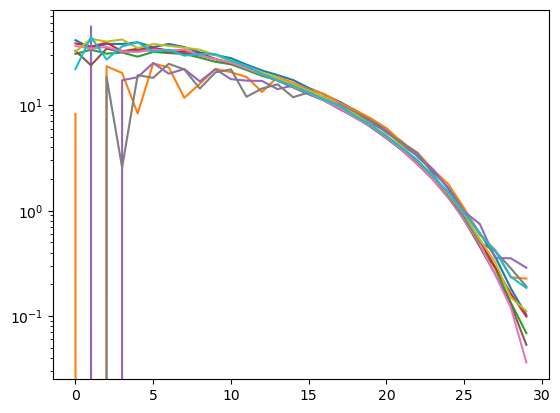

In [11]:
import matplotlib.pyplot as plt
for i in range(0, 100, 10):
    plt.plot(wp_array[i]['wp'])
plt.semilogy()